In [1]:
import os
import sys
import torch

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from src import BASE_DIR

from src.models.dcgan_lsun import *
import numpy as np
from matplotlib import pyplot as plt
from src.utils.visualization import create_grid_image

/home/daoduyhung/anaconda3/envs/cs231n_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daoduyhung/anaconda3/envs/cs231n_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/daoduyhung/anaconda3/envs/cs231n_env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


# Investigating and visualizing the internals of the networks

## 1. Walking in latent space

(-0.5, 661.5, 661.5, -0.5)

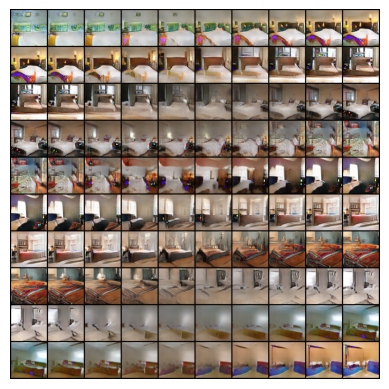

In [2]:
torch.manual_seed(2405)
# noise
num_noise = 11
noises = torch.randn(num_noise, 100)
G = Generator(ngf=128)
try:
    G.load_state_dict(torch.load(os.path.join(BASE_DIR,'models/LSUN/gen_params_2.pth')))
except FileNotFoundError:
    print("Not exist model params. You can train model with LSUN dataset or get pretrained param from this link: https://drive.google.com/file/d/16hnQmRKY4x3gPFI2lxydqAtakmnfVISm/view?usp=sharing")


interpolated_list = []
# interpolation between 2 noise point
with torch.no_grad():
    for i in range(num_noise - 1):
        z1, z2 = noises[i], noises[i+1]
        for coef in np.linspace(0,1,10):
            interpolated = (1 - coef) * z1 + coef * z2
            interpolated_list.append(interpolated)

images = G(torch.stack(interpolated_list))
grid_image = create_grid_image(images=images, nimage_row=10, save=True, path_to_save=os.path.join(BASE_DIR,'reports/LSUN/interpolated.png'))
plt.imshow(grid_image)
plt.axis('off')


## 2. Visualizing discriminator features

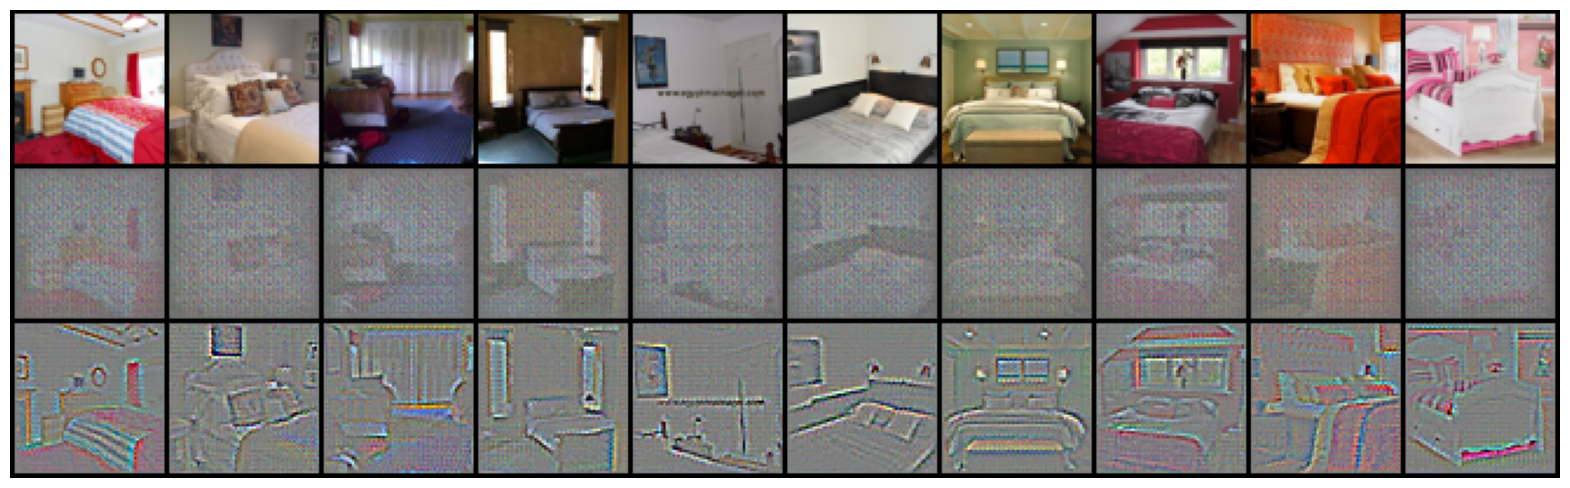

In [50]:
from torchvision import transforms
from src.utils. guided_backpropgation import GuidedBackprop
from src.data.LSUN.transforms import *

listdir = os.listdir('../../DCGAN/data/LSUN/bedroom_train_data/')
num_image = 10
paths = listdir[:num_image]

model = Discriminator()
model.load_state_dict(torch.load(os.path.join(BASE_DIR, 'models/LSUN/dis_params_2.pth')))

base_model = Discriminator()

learned_gbp = GuidedBackprop(model)
base_gbp = GuidedBackprop(base_model)
learned_gbp.register_hooks()
base_gbp.register_hooks()

grid = []

for path in paths:
    image = Image.open(os.path.join(BASE_DIR,'data/LSUN/bedroom_train_data/', path))

    composed = transforms.Compose([
        CenterCrop(),
        ReScale(64),
        transforms.ToTensor()
    ])

    image = composed(image)
    learned_result = learned_gbp.generate_reconstructed_image(image.unsqueeze(0).requires_grad_())
    base_result = base_gbp.generate_reconstructed_image(image.unsqueeze(0).requires_grad_())
    grid.extend([image, base_result, learned_result])


grid = torch.stack(grid).reshape(num_image,3,*(grid[0].shape)).transpose(1,0).reshape(-1,*(grid[0].shape))
grid_image = create_grid_image(grid, nimage_row=10, save=True, path_to_save=os.path.join(BASE_DIR,'reports/LSUN/guided_bp.png'))

fig = plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(grid_image)


In [56]:
import os
import datetime

# Get current date and time
now = datetime.datetime.now()

# Create folder with current date and time as name
folder_name = now.strftime("%Y%m%d%H")
folder_name

'2023051015'